In [1]:
import gym
from gym import wrappers
import time
import os
import numpy as np
import pickle
import math
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# If you have more than 1 GPU, you might want to specify which GPU for training.
os.environ['CUDA_VISIBLE_DEVICES']='0' # The second
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
GPU is available


# Constants

In [2]:
folder_name = '20220107_CartPole_SAC'
env_name = 'CartPole-v1'
monitor_name = f"./{folder_name}_monitor"
env = gym.make(env_name)

In [3]:
n_state = 4
n_action = 2
epsilon = 1e-6
alpha = 0.2

# See the statistics

  0%|          | 0/1000 [00:00<?, ?it/s]

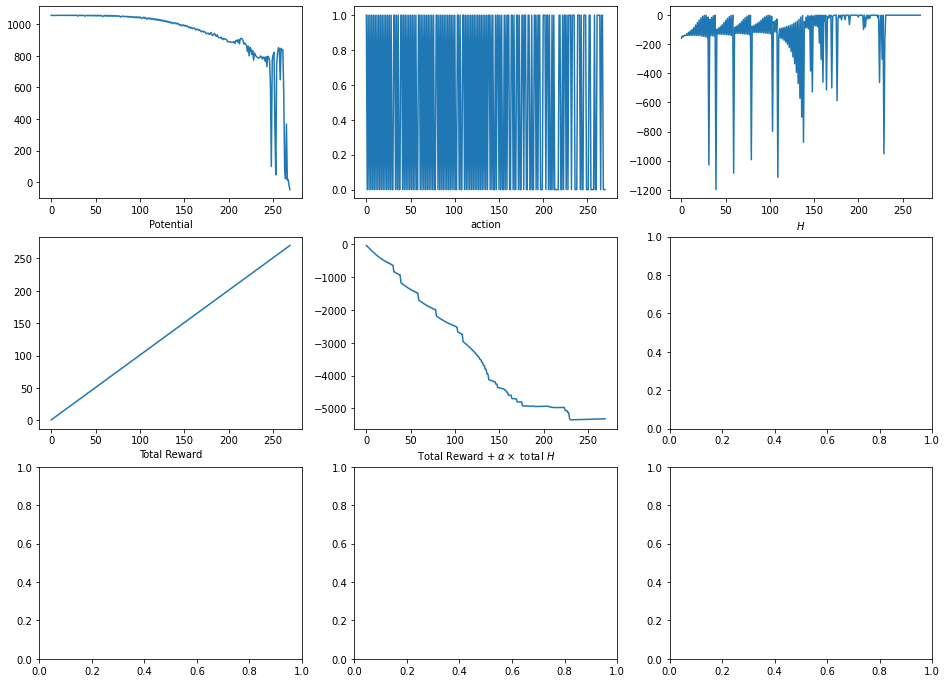

In [28]:
env.close()
st = time.time()
n_trial = 1
n_step = 1000
entropy_object = tf.keras.losses.CategoricalCrossentropy(reduction = 'none', from_logits = True)


for i in range(n_trial):
    # Initialize a New Env
    if env:
        env.close()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, monitor_name, force=True)
    state = env.reset()
    actor = load_model(f'{folder_name}/actor_current.h5')
    r_func = load_model(f'{folder_name}/r_func_current.h5')
    
    state_list = []
    mu_list = []
    sigma_list = []
    action_list = []
    log_prob_list = []
    reward_list = []
    r = 0
    
    pbar = tqdm(range(n_step))
    for char in pbar:
        pbar.set_description("Potential %s" % r)
        prob = actor(np.array([state]))
        log_prob = tf.math.log(prob)
        a = tf.random.categorical(log_prob, 1)
        action = a.numpy()[0,0]
        #action = np.argmax(prob[0])
        
        state, reward, done, info = env.step(action)
        state_list.append(state)
        action_list.append(action)
        log_prob_list.append(log_prob[0].numpy())
        reward_list.append(reward)
        s = np.reshape(np.array(state, dtype = np.float32), (1,n_state))
        a = np.reshape(np.array(action, dtype = np.int32), (1,1))
        r = r_func([s, a]).numpy()[0,0]
        if done:
            break
    state_array = np.array(state_list)
    action_array = np.array(action_list)
    reward_array = np.array(reward_list)
    total_reward_array = np.array([ np.sum(reward_array[:i+1]) for i in range(len(reward_array))])
    r_array = r_func([state_array, action_array]).numpy()
    entropy = entropy_object(log_prob_list, log_prob_list)
    total_entropy = np.array([ np.sum(entropy[:i+1]) for i in range(len(entropy))])
    fig, axes = plt.subplots(3,3, figsize= (16,12))
    axes = axes.flatten()
    
    axes[0].plot(r_array[:-1])
    axes[0].set_xlabel('Potential')
    
    axes[1].plot(action_array)
    axes[1].set_xlabel(r'action')
    
    axes[2].plot(entropy)
    axes[2].set_xlabel(r'$H$')
    
    axes[3].plot(total_reward_array[:-1])
    axes[3].set_xlabel(r'Total Reward')
    
    axes[4].plot(alpha * total_entropy[:-1] + total_reward_array[:-1])
    axes[4].set_xlabel(r'Total Reward + $\alpha \times$ total $H$')
    
    plt.show()
    
env.close()

In [5]:
env.close()